In [ ]:
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Loaded Dataset Shape: (15680, 2)
Sample Data:
                         title  \
0            A Line-storm Song   
1              The Weary Blues   
2  Morning in the Burned House   
3                    On Living   
4     I Could Be a Whale Shark   

                                                body  
0  \nThe line-storm clouds fly tattered and swift...  
1  \nDroning a drowsy syncopated tune, Rocking ba...  
2  \nIn the burned house I am eating breakfast. Y...  
3  \n\n\n\n\n\n\n\nit’s 1962 March 28th I’m sitti...  
4  \n\n\nWhen I say first time, that implies ther...  

Cleaned Dataset Shape: (11680, 3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/11680 [00:00<?, ? examples/s]

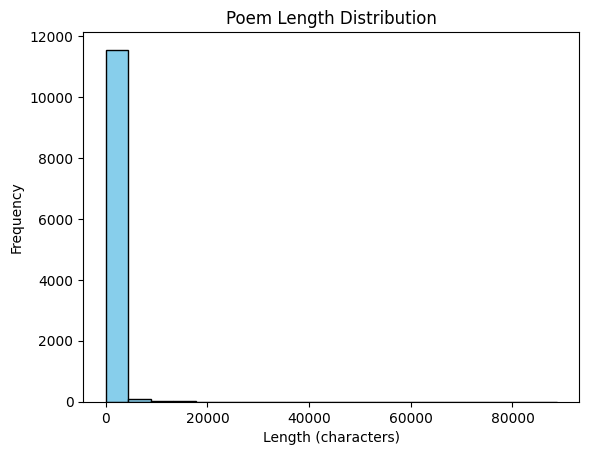

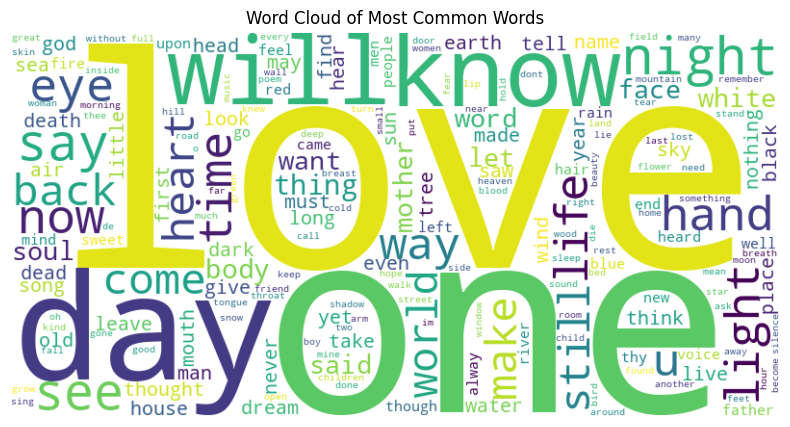


Cleaned Data Samples:
                         title  \
0            A Line-storm Song   
1              The Weary Blues   
2  Morning in the Burned House   
3                    On Living   
4     I Could Be a Whale Shark   

                                        cleaned_body  
0  the linestorm clouds fly tattered and swift th...  
1  droning a drowsy syncopated tune rocking back ...  
2  in the burned house i am eating breakfast you ...  
3  its 1962 march 28th im sitting by the window o...  
4  when i say first time that implies there will ...  

Cleaned dataset saved as '/content/cleaned_ppoems.json'


In [ ]:
# Import Libraries
import pandas as pd
import json
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Load the Dataset
file_path = "/content/ppoems.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)
print("Loaded Dataset Shape:", df.shape)
print("Sample Data:")
print(df.head())

# Data Cleansing
def clean_text(text):
    """Cleans and normalizes text data."""
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\n+', ' ', text)
    return text

df['cleaned_body'] = df['body'].apply(clean_text)

# Drop records with missing or empty bodies
df = df[df['cleaned_body'].notnull() & (df['cleaned_body'] != '')]
print("\nCleaned Dataset Shape:", df.shape)

dataset = Dataset.from_pandas(df)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    """Tokenizes the cleaned_body field."""
    return tokenizer(examples['cleaned_body'], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

#  Exploratory Data Analysis (EDA)
df_cleaned = tokenized_dataset.to_pandas()

# Poem Length Distribution
df_cleaned['length'] = df_cleaned['cleaned_body'].apply(len)
plt.hist(df_cleaned['length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Poem Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Word Cloud for Original Text
all_text = ' '.join(df['cleaned_body'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words")
plt.show()

# Printing Cleaned Data Samples
print("\nCleaned Data Samples:")
print(df_cleaned[['title', 'cleaned_body']].head())

# Save Cleaned Dataset to JSON
df_cleaned.to_json("/content/cleaned_ppoems.json", orient='records', lines=True)
print("\nCleaned dataset saved as '/content/cleaned_ppoems.json'")
